# 安装库

In [ ]:
# 安装必要的库
%pip install requests
%pip install openai
%pip install langgraph langchain-openai

# 示例

In [11]:
import os
from openai import OpenAI

# 设置您的 API 密钥
YOUR_API_KEY = "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"
os.environ["PPLX_API_KEY"] = YOUR_API_KEY

# 初始化 API 客户端
client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")

# 定义聊天机器人函数
def chatbot(messages):
    response = client.chat.completions.create(
        model="llama-3.1-sonar-large-128k-online",
        messages=messages,
    )
    return response.choices[0].message.content

# 定义天气查询工具函数
def get_weather():
    return "今天的天气是晴天，温度25℃"

# 运行状态图并传递用户输入
user_input = "合肥今天天气怎么样？"
messages = [
    {
        "role": "system",
        "content": (
            "You are an artificial intelligence assistant and you need to "
            "engage in a helpful, detailed, polite conversation with a user."
        ),
    },
    {
        "role": "user",
        "content": user_input,
    },
]

# 获取聊天机器人响应
chat_response = chatbot(messages)

# 输出结果消息内容
print(chat_response)

# 如果需要使用天气查询工具，可以直接调用
weather_response = get_weather()
print(weather_response)

根据最新的天气预报，以下是关于合肥今天（11月28日）天气的信息：

## 气温
今天的气温范围为1°C到11°C[4][5].

## 天气状况
天气预报显示今天将是晴天，可能没有明显的降水[4][5].

## 风力
风向主要是西风或西北风，风力在3-5级之间[4][5].

## 其他建议
- 由于气温较低，建议着厚外套加毛衣等服装。
- 风力较大，洗车后可能会蒙上灰尘。
- 辐射较弱，建议涂擦SPF12-15、PA+防晒护肤品。
- 在户外运动时请注意增减衣物[5].
今天的天气是晴天，温度25℃


# 简单动态工作流

In [13]:
import json
import os
import re
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Annotated
import operator

# 设置您的 API 密钥
YOUR_API_KEY = "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"
os.environ["PPLX_API_KEY"] = YOUR_API_KEY

# 初始化 API 客户端
client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")

# 定义状态结构
class Task(TypedDict):
    id: str
    description: str
    depends_on: List[str]

class PlanState(TypedDict):
    tasks: Annotated[List[str], operator.add]  # 使用 operator.add 作为合并函数

# 1. 使用 LLM 生成结构化计划
def generate_plan(user_input):
    prompt = f"""
    请根据以下用户输入生成一个结构化计划，格式为纯 JSON，不要添加任何其他文本：
    用户输入: "{user_input}"
    输出格式:
    {{
        "tasks": [
            {{"id": "task1", "description": "任务描述1", "depends_on": []}},
            {{"id": "task2", "description": "任务描述2", "depends_on": ["task1"]}}
        ]
    }}
    """
    
    messages = [
        {
            "role": "system",
            "content": (
                "You are an artificial intelligence assistant and you need to "
                "generate a structured plan based on user input."
            ),
        },
        {
            "role": "user",
            "content": prompt,
        },
    ]
    
    response = client.chat.completions.create(
        model="llama-3.1-sonar-large-128k-online",
        messages=messages,
    )
    
    json_content = response.choices[0].message.content
    json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

    if json_match:
        json_str = json_match.group(0)
        return json.loads(json_str)
    
    return None

# 示例用户输入
user_input = "准备一次旅行，包括订机票和酒店"
plan = generate_plan(user_input)
print("生成的计划:", plan)

# 2. 将计划转换为图结构
def build_graph(plan):
    graph_builder = StateGraph(state_schema=PlanState)

    for task in plan["tasks"]:
        task_id = task["id"]
        description = task["description"]
        
        def task_node(state: PlanState, task_description=description):
            print(f"执行: {task_description}")
            current_tasks = state.get("tasks", [])
            return {"tasks": current_tasks + [task_description]}  # 返回合并后的任务列表
        
        graph_builder.add_node(task_id, lambda state, desc=description: task_node(state, desc)) 

    for task in plan["tasks"]:
        task_id = task["id"]
        dependencies = task["depends_on"]
        
        if not dependencies:
            graph_builder.add_edge(START, task_id)
        
        for dep in dependencies:
            graph_builder.add_edge(dep, task_id)

    for task in plan["tasks"]:
        graph_builder.add_edge(task["id"], END)
    
    return graph_builder.compile()

# 构建图结构并执行
if plan:
    graph = build_graph(plan)

    # 调试输出图结构
    print("图结构:")
    for node in graph.nodes:
        print(f"Node ID: {node}")

    # 执行图并捕获异常
    try:
        initial_input = {"tasks": []}  # 初始状态可以根据需要调整
        response = graph.invoke(initial_input)
        print("所有任务已完成")
    except Exception as e:
        print(f"执行图时发生错误: {e}")

生成的计划: {'tasks': [{'id': 'task1', 'description': '研究和选择目的地', 'depends_on': []}, {'id': 'task2', 'description': '收集目的地的旅游信息（景点、酒店、交通等）', 'depends_on': ['task1']}, {'id': 'task3', 'description': '比较和选择机票', 'depends_on': ['task2']}, {'id': 'task4', 'description': '预订机票', 'depends_on': ['task3']}, {'id': 'task5', 'description': '比较和选择酒店', 'depends_on': ['task2']}, {'id': 'task6', 'description': '预订酒店', 'depends_on': ['task5']}, {'id': 'task7', 'description': '规划详细行程（包括交通、景点、餐厅等）', 'depends_on': ['task4', 'task6']}, {'id': 'task8', 'description': '确认和打印所有预订信息', 'depends_on': ['task7']}]}
图结构:
Node ID: __start__
Node ID: task1
Node ID: task2
Node ID: task3
Node ID: task4
Node ID: task5
Node ID: task6
Node ID: task7
Node ID: task8
执行: 研究和选择目的地
执行: 收集目的地的旅游信息（景点、酒店、交通等）
执行: 比较和选择机票
执行: 比较和选择酒店
执行: 预订机票
执行: 预订酒店
执行: 规划详细行程（包括交通、景点、餐厅等）
执行: 确认和打印所有预订信息
所有任务已完成


# 可视化

In [ ]:
%pip install networkx matplotlib

生成的计划: {'tasks': [{'id': 'task1', 'description': '确定旅行目的地和日期', 'depends_on': []}, {'id': 'task2', 'description': '搜索和比较机票价格', 'depends_on': ['task1']}, {'id': 'task3', 'description': '预订机票', 'depends_on': ['task2']}, {'id': 'task4', 'description': '搜索和比较酒店价格', 'depends_on': ['task1']}, {'id': 'task5', 'description': '预订酒店', 'depends_on': ['task4']}, {'id': 'task6', 'description': '规划旅行行程，包括景点和活动', 'depends_on': ['task3', 'task5']}, {'id': 'task7', 'description': '确认和保存旅行计划', 'depends_on': ['task6']}]}
图结构:
Node ID: task1
Node ID: task2
Node ID: task3
Node ID: task4
Node ID: task5
Node ID: task6
Node ID: task7


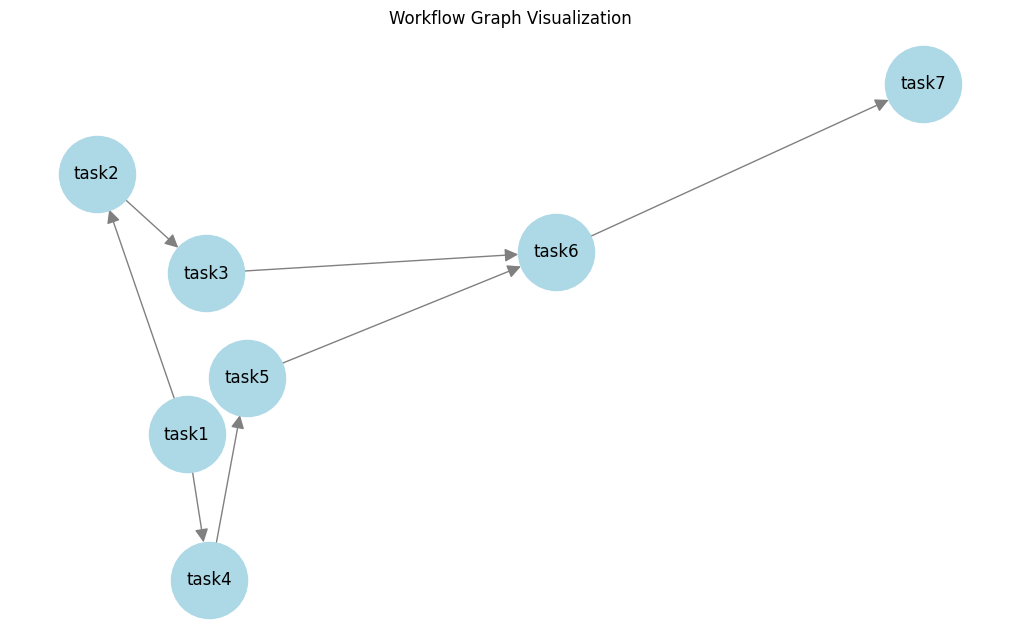

In [40]:
import json
import os
import re
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Annotated
import operator
import networkx as nx
import matplotlib.pyplot as plt

# 设置您的 API 密钥
YOUR_API_KEY = "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"
os.environ["PPLX_API_KEY"] = YOUR_API_KEY

# 初始化 API 客户端
client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")

# 定义状态结构
class Task(TypedDict):
    id: str
    description: str
    depends_on: List[str]

class PlanState(TypedDict):
    tasks: Annotated[List[str], operator.add]  # 使用 operator.add 作为合并函数

# 1. 使用 LLM 生成结构化计划
def generate_plan(user_input):
    prompt = f"""
    请根据以下用户输入生成一个结构化计划，格式为纯 JSON，不要添加任何其他文本：
    用户输入: "{user_input}"
    输出格式:
    {{
        "tasks": [
            {{"id": "task1", "description": "任务描述1", "depends_on": []}},
            {{"id": "task2", "description": "任务描述2", "depends_on": ["task1"]}}
        ]
    }}
    """
    
    messages = [
        {
            "role": "system",
            "content": (
                "You are an artificial intelligence assistant and you need to "
                "generate a structured plan based on user input."
            ),
        },
        {
            "role": "user",
            "content": prompt,
        },
    ]
    
    response = client.chat.completions.create(
        model="llama-3.1-sonar-large-128k-online",
        messages=messages,
    )
    
    json_content = response.choices[0].message.content
    json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

    if json_match:
        json_str = json_match.group(0)
        return json.loads(json_str)
    
    return None

# 示例用户输入
user_input = "准备一次旅行，包括订机票和酒店"
plan = generate_plan(user_input)
print("生成的计划:", plan)

# 2. 将计划转换为图结构并提取节点和边信息
def build_graph(plan):
    graph_builder = StateGraph(state_schema=PlanState)

    nodes = []
    edges = []

    for task in plan["tasks"]:
        task_id = task["id"]
        description = task["description"]
        
        def task_node(state: PlanState, task_description=description):
            print(f"执行: {task_description}")
            current_tasks = state.get("tasks", [])
            return {"tasks": current_tasks + [task_description]}
        
        graph_builder.add_node(task_id, lambda state, desc=description: task_node(state, desc))
        
        # 添加节点到列表（用于可视化）
        nodes.append(task_id)

    for task in plan["tasks"]:
        task_id = task["id"]
        dependencies = task["depends_on"]
        
        if not dependencies:
            graph_builder.add_edge(START, task_id)  # 无依赖任务从 START 开始
        
        for dep in dependencies:
            graph_builder.add_edge(dep, task_id)  # 添加依赖边
            
            # 添加边到列表（用于可视化）
            edges.append((dep, task_id))

    for task in plan["tasks"]:
        graph_builder.add_edge(task["id"], END)  # 所有任务完成后连接到 END
    
    return graph_builder.compile(), nodes, edges

# 构建图结构并提取节点和边信息
if plan:
    graph, nodes, edges = build_graph(plan)

    # 调试输出图结构
    print("图结构:")
    for node in nodes:
        print(f"Node ID: {node}")

# 3. 可视化工作流图结构
def visualize_graph(nodes, edges):
    G = nx.DiGraph()  # 创建有向图

    # 添加节点和边
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # 绘制图形
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)  # 自动布局算法，生成节点位置
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color='lightblue',
        arrowsize=20,
        node_size=3000,
        edge_color='gray'
    )
    
    plt.title('Workflow Graph Visualization')
    plt.show()

# 调用可视化函数
if plan:
    visualize_graph(nodes, edges)

# 复杂动态工作流

## 端侧

In [5]:
import json
import os
import re
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Annotated
import operator
from openai import OpenAI

# 设置您的 API 密钥
YOUR_API_KEY = "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"
os.environ["PPLX_API_KEY"] = YOUR_API_KEY

class Task(TypedDict):
    id: str
    description: str
    depends_on: List[str]

class PlanState(TypedDict):
    tasks: Annotated[List[str], operator.add]  # 使用 operator.add 作为合并函数

class EndPlanGraph:
    def __init__(self):
        self.client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")
        self.plan = None
        self.graph = None

    def generate_plan(self, user_input: str):
        prompt = f"""
        请根据以下用户输入生成一个结构化计划，格式为纯 JSON，不要添加任何其他文本：
        用户输入: "{user_input}"
        输出格式:
        {{
            "tasks": [
                {{"id": "task1", "description": "任务描述1", "depends_on": []}},
                {{"id": "task2", "description": "任务描述2", "depends_on": ["task1"]}}
            ]
        }}
        """
        
        messages = [
            {
                "role": "system",
                "content": (
                    "You are an artificial intelligence assistant and you need to "
                    "generate a structured plan based on user input."
                ),
            },
            {
                "role": "user",
                "content": prompt,
            },
        ]
        
        response = self.client.chat.completions.create(
            model="llama-3.1-sonar-large-128k-online",
            messages=messages,
        )
        
        json_content = response.choices[0].message.content
        json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

        if json_match:
            json_str = json_match.group(0)
            self.plan = json.loads(json_str)
            print("生成的子任务的计划:", self.plan)
    
    def build_graph(self):
        if not self.plan:
            raise ValueError("没有可用的计划，请先生成计划。")
        
        graph_builder = StateGraph(state_schema=PlanState)

        for task in self.plan["tasks"]:
            task_id = task["id"]
            description = task["description"]
            
            def task_node(state: PlanState, task_description=description):
                print(f"执行: {task_description}")
                # 此处如果允许可以设置成异步调用（考虑依赖关系）
                current_tasks = state.get("tasks", [])
                return {"tasks": current_tasks + [task_description]}
            
            graph_builder.add_node(task_id, lambda state, desc=description: task_node(state, desc))

        for task in self.plan["tasks"]:
            task_id = task["id"]
            dependencies = task["depends_on"]
            
            if not dependencies:
                graph_builder.add_edge(START, task_id)
            
            for dep in dependencies:
                graph_builder.add_edge(dep, task_id)

        for task in self.plan["tasks"]:
            graph_builder.add_edge(task["id"], END)
        
        self.graph = graph_builder.compile()
    
    def execute_graph(self):
        if not self.graph:
            raise ValueError("没有可用的图，请先构建图。")
        
        try:
            initial_input = {"tasks": []}
            response = self.graph.invoke(initial_input)
            print("该子任务已完成")
        except Exception as e:
            print(f"执行图时发生错误: {e}")

    def run(self, user_input: str):
        self.generate_plan(user_input)
        self.build_graph()
        self.execute_graph()

# 使用示例
if __name__ == "__main__":
    travel_plan_graph = EndPlanGraph()
    travel_plan_graph.run("准备一次旅行，包括订机票和酒店")

生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': '搜索和比较机票价格', 'depends_on': []}, {'id': 'task2', 'description': '订购机票', 'depends_on': ['task1']}, {'id': 'task3', 'description': '搜索和比较酒店价格和评价', 'depends_on': []}, {'id': 'task4', 'description': '订购酒店', 'depends_on': ['task3']}, {'id': 'task5', 'description': '确认旅行计划并保存相关信息', 'depends_on': ['task2', 'task4']}]}
执行: 搜索和比较机票价格
执行: 搜索和比较酒店价格和评价
执行: 订购机票
执行: 订购酒店
执行: 确认旅行计划并保存相关信息
该子任务已完成


## 云侧

In [ ]:
class CloudPlanGraph:
    def __init__(self):
        self.client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")
        self.plan = None
        self.graph = None

    def generate_plan(self, user_input: str):
        prompt = f"""
        请根据以下用户输入生成一个结构化计划，格式为纯 JSON，不要添加任何其他文本：
        用户输入: "{user_input}"
        输出格式:
        {{
            "tasks": [
                {{"id": "task1", "description": "任务描述1", "depends_on": []}},
                {{"id": "task2", "description": "任务描述2", "depends_on": ["task1"]}}
            ]
        }}
        """
        
        messages = [
            {
                "role": "system",
                "content": (
                    "You are an artificial intelligence assistant and you need to "
                    "generate a structured plan based on user input."
                ),
            },
            {
                "role": "user",
                "content": prompt,
            },
        ]
        
        response = self.client.chat.completions.create(
            model="llama-3.1-sonar-large-128k-online",
            messages=messages,
        )
        
        json_content = response.choices[0].message.content
        json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

        if json_match:
            json_str = json_match.group(0)
            self.plan = json.loads(json_str)
            print("云侧生成的计划:", self.plan)
    
    def build_graph(self):
        if not self.plan:
            raise ValueError("没有可用的计划，请先生成计划。")
        
        graph_builder = StateGraph(state_schema=PlanState)

        for task in self.plan["tasks"]:
            task_id = task["id"]
            description = task["description"]
            
            def task_node(state: PlanState, task_description=description):
                print(f"调用Agents来完成子任务: {task_description}")
                # 此处如果允许可以设置成异步调用（考虑依赖关系）
                # 调用EndPlanGraph中的run方法
                end_plan_graph = EndPlanGraph()
                end_plan_graph.run(task_description)

                current_tasks = state.get("tasks", [])
                return {"tasks": current_tasks + [task_description]}
            
            graph_builder.add_node(task_id, lambda state, desc=description: task_node(state, desc))

        for task in self.plan["tasks"]:
            task_id = task["id"]
            dependencies = task["depends_on"]
            
            if not dependencies:
                graph_builder.add_edge(START, task_id)
            
            for dep in dependencies:
                graph_builder.add_edge(dep, task_id)

        for task in self.plan["tasks"]:
            graph_builder.add_edge(task["id"], END)
        
        self.graph = graph_builder.compile()
    
    def execute_graph(self):
        if not self.graph:
            raise ValueError("没有可用的图，请先构建图。")
        
        try:
            initial_input = {"tasks": []}
            response = self.graph.invoke(initial_input)
            print("所有任务已完成")
        except Exception as e:
            print(f"执行图时发生错误: {e}")

    def run(self, user_input: str):
        self.generate_plan(user_input)
        self.build_graph()
        self.execute_graph()

# 使用示例
if __name__ == "__main__":
    travel_plan_graph = CloudPlanGraph()
    travel_plan_graph.run("准备一次旅行，包括订机票和酒店")

云侧生成的计划: {'tasks': [{'id': 'task1', 'description': '通过视觉检测代理识别桌子上的红色球', 'depends_on': []}, {'id': 'task2', 'description': '通过数据处理代理确认红色球的位置和状态', 'depends_on': ['task1']}, {'id': 'task3', 'description': '发送指令给机械臂控制代理，执行抓取红色球的操作', 'depends_on': ['task2']}, {'id': 'task4', 'description': '通过机械臂控制代理移动红色球到架子上', 'depends_on': ['task3']}, {'id': 'task5', 'description': '通过视觉检测代理确认红色球已成功放置在架子上', 'depends_on': ['task4']}]}
调用Agents来完成子任务: 通过视觉检测代理识别桌子上的红色球
调用Agents来完成子任务: 通过数据处理代理确认红色球的位置和状态
调用Agents来完成子任务: 发送指令给机械臂控制代理，执行抓取红色球的操作
调用Agents来完成子任务: 通过机械臂控制代理移动红色球到架子上
调用Agents来完成子任务: 通过视觉检测代理确认红色球已成功放置在架子上
所有任务已完成


## 场景化（function call、parameter）

### 机械臂控制代理

In [50]:
import json
import os
import re
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Annotated
import operator
from openai import OpenAI

# 设置您的 API 密钥
YOUR_API_KEY = "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"
os.environ["PPLX_API_KEY"] = YOUR_API_KEY

class Task(TypedDict):
    id: str
    description: str
    api_name: str  # 新增字段，用于指定调用的API名称
    api_params: dict  # 新增字段，用于指定API参数
    depends_on: List[str]

class PlanState(TypedDict):
    tasks: Annotated[List[str], operator.add]  # 使用 operator.add 作为合并函数

class ArmPlanGraph:
    def __init__(self):
        self.client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")
        self.plan = None
        self.graph = None

    def generate_plan(self, user_input: str):
        prompt = f"""
        ### API 描述

        1. **抓取物体 API**
        - **名称**：抓取物体
        - **参数**：
            - `object_id`: 要抓取的物体的ID。
            - `gripper_type`: 使用的抓手类型。

        2. **移动物体 API**
        - **名称**：移动物体
        - **参数**：
            - `object_id`: 要移动的物体的ID。
            - `target_position`: 目标位置的坐标。

        3. **释放物体 API**
        - **名称**：释放物体
        - **参数**：
            - `object_id`: 要释放的物体的ID。
            - `release_position`: 释放位置的坐标。

        4. **设置关节角度 API**
        - **名称**：设置关节角度
        - **参数**：
            - `joint_id`: 要设置的关节的ID。
            - `angle`: 要设置的角度。

        5. **复位机械臂 API**
        - **名称**：复位机械臂
        - **参数**：无
        
        请根据以下用户输入生成一个结构化计划，格式为纯 JSON，不要添加任何其他文本：
        
        用户输入: "{user_input}"
        
        输出格式:
        {{
            "tasks": [
                {{"id": "task1", "description": "任务描述1", "api_name": "API名称1", "api_params": {{"param1": "value1"}},"depends_on": []}},
                {{"id": "task2", "description": "任务描述2", "api_name": "API名称2", "api_params": {{"param2": "value2"}}, "depends_on": ["task1"]}}
            ]
        }}
        
        请确保在每个子任务中包含要调用的API名称和相应的参数，以便于后续调用。
        """

        messages = [
            {
                "role": "system",
                "content": (
                    "You are an artificial intelligence assistant and you need to "
                    "generate a structured plan based on user input."
                ),
            },
            {
                "role": "user",
                "content": prompt,
            },
        ]
        
        response = self.client.chat.completions.create(
            model="llama-3.1-sonar-large-128k-online",
            messages=messages,
        )
        
        json_content = response.choices[0].message.content
        json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

        if json_match:
            json_str = json_match.group(0)
            self.plan = json.loads(json_str)
            print("生成的子任务的计划:", self.plan)
    
    def build_graph(self):
        if not self.plan:
            raise ValueError("没有可用的计划，请先生成计划。")
        
        graph_builder = StateGraph(state_schema=PlanState)

        for task in self.plan["tasks"]:
            task_id = task["id"]
            description = task["description"]
            api_name = task["api_name"]
            api_params = task["api_params"]
            
            def task_node(state: PlanState, task_description=description, api_name=api_name, api_params=api_params):
                print(f"执行: {task_description}，调用API: {api_name}，参数: {api_params}")
                # 此处可以调用实际的API，例如：
                # response = call_api(api_name, api_params)
                
                current_tasks = state.get("tasks", [])
                return {"tasks": current_tasks + [task_description]}
            
            graph_builder.add_node(task_id, lambda state, desc=description, name=api_name, params=api_params: task_node(state, desc, name, params))

        for task in self.plan["tasks"]:
            task_id = task["id"]
            dependencies = task["depends_on"]
            
            if not dependencies:
                graph_builder.add_edge(START, task_id)
            
            for dep in dependencies:
                graph_builder.add_edge(dep, task_id)

        for task in self.plan["tasks"]:
            graph_builder.add_edge(task["id"], END)
        
        self.graph = graph_builder.compile()
    
    def execute_graph(self):
        if not self.graph:
            raise ValueError("没有可用的图，请先构建图。")
        
        try:
            initial_input = {"tasks": []}
            response = self.graph.invoke(initial_input)
            print("该子任务已完成")
        except Exception as e:
            print(f"执行图时发生错误: {e}")

    def run(self, user_input: str):
        self.generate_plan(user_input)
        self.build_graph()
        self.execute_graph()

# 使用示例
if __name__ == "__main__":
    travel_plan_graph = ArmPlanGraph()
    travel_plan_graph.run("抓取桌子上的红色球。")

生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': '识别和定位桌子上的红色球', 'api_name': '抓取物体 API', 'api_params': {'object_id': '红色球的ID', 'gripper_type': '适合抓取球的抓手类型'}, 'depends_on': []}, {'id': 'task2', 'description': '移动机械臂到抓取位置', 'api_name': '设置关节角度 API', 'api_params': {'joint_id': '机械臂关节的ID', 'angle': '计算出的抓取角度'}, 'depends_on': ['task1']}, {'id': 'task3', 'description': '执行抓取操作', 'api_name': '抓取物体 API', 'api_params': {'object_id': '红色球的ID', 'gripper_type': '适合抓取球的抓手类型'}, 'depends_on': ['task2']}]}
执行: 识别和定位桌子上的红色球，调用API: 抓取物体 API，参数: {'object_id': '红色球的ID', 'gripper_type': '适合抓取球的抓手类型'}
执行: 移动机械臂到抓取位置，调用API: 设置关节角度 API，参数: {'joint_id': '机械臂关节的ID', 'angle': '计算出的抓取角度'}
执行: 执行抓取操作，调用API: 抓取物体 API，参数: {'object_id': '红色球的ID', 'gripper_type': '适合抓取球的抓手类型'}
该子任务已完成


### 视觉检测代理

In [36]:
import json
import os
import re
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Annotated
import operator
from openai import OpenAI

# 设置您的 API 密钥
YOUR_API_KEY = "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"
os.environ["PPLX_API_KEY"] = YOUR_API_KEY

class Task(TypedDict):
    id: str
    description: str
    api_name: str  # 用于指定调用的API名称
    api_params: dict  # 用于指定API参数
    depends_on: List[str]

class PlanState(TypedDict):
    tasks: Annotated[List[str], operator.add]  # 使用 operator.add 作为合并函数

class EyePlanGraph:
    def __init__(self):
        self.client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")
        self.plan = None
        self.graph = None

    def generate_plan(self, user_input: str):
        prompt = f"""
        ### API 描述

        1. **检测物体位置 API**
        - **名称**检测物体位置
        - **参数**：
            - `object_id`: 要检测的物体的ID。
            - `camera_id`: 使用的相机ID。
            
        2. **识别物体特征 API**
        - **名称**：识别物体特征
        - **参数**：
            - `object_id`: 要识别的物体的ID。
            - `feature_type`:  要识别的特征类型（如颜色、形状、大小、材质）。

        3. **获取物体边界框 API**
        - **名称**：获取物体边界框
        - **参数**：
            - `object_id`: 要获取边界框的物体的ID。
            - `camera_id`: 使用的相机ID。

        4. **计算物体位置相对坐标 API**
        - **名称**：计算物体位置相对坐标
        - **参数**：
            - `object_id`: 要计算相对坐标的物体的ID。
            - `reference_object_id`: 参考物体的ID。
                    
        请根据以下用户输入生成一个结构化计划，格式为纯 JSON，不要添加任何其他文本：
        
        用户输入: "{user_input}"
        
        输出格式:
        {{
            "tasks": [
                {{"id": "task1", "description": "任务描述1", "api_name": "API名称1", "api_params": {{"param1": "value1"}},"depends_on": []}},
                {{"id": "task2", "description": "任务描述2", "api_name": "API名称2", "api_params": {{"param2": "value2"}}, "depends_on": ["task1"]}}
            ]
        }}
        
        请确保在每个子任务中包含要调用的API名称和相应的参数，以便于后续调用。
        """

        messages = [
            {
                "role": "system",
                "content": (
                    "You are an artificial intelligence assistant and you need to "
                    "generate a structured plan based on user input."
                ),
            },
            {
                "role": "user",
                "content": prompt,
            },
        ]
        
        response = self.client.chat.completions.create(
            model="llama-3.1-sonar-large-128k-online",
            messages=messages,
        )
        
        json_content = response.choices[0].message.content
        json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

        if json_match:
            json_str = json_match.group(0)
            self.plan = json.loads(json_str)
            print("生成的子任务的计划:", self.plan)
    
    def build_graph(self):
        if not self.plan:
            raise ValueError("没有可用的计划，请先生成计划。")
        
        graph_builder = StateGraph(state_schema=PlanState)

        for task in self.plan["tasks"]:
            task_id = task["id"]
            description = task["description"]
            api_name = task["api_name"]
            api_params = task["api_params"]
            
            def task_node(state: PlanState, task_description=description, api_name=api_name, api_params=api_params):
                print(f"执行: {task_description}，调用API: {api_name}，参数: {api_params}")
                # 此处可以调用实际的API，例如：
                # response = call_api(api_name, api_params)
                
                current_tasks = state.get("tasks", [])
                return {"tasks": current_tasks + [task_description]}
            
            graph_builder.add_node(task_id, lambda state, desc=description, name=api_name, params=api_params: task_node(state, desc, name, params))

        for task in self.plan["tasks"]:
            task_id = task["id"]
            dependencies = task["depends_on"]
            
            if not dependencies:
                graph_builder.add_edge(START, task_id)
            
            for dep in dependencies:
                graph_builder.add_edge(dep, task_id)

        for task in self.plan["tasks"]:
            graph_builder.add_edge(task["id"], END)
        
        self.graph = graph_builder.compile()
    
    def execute_graph(self):
        if not self.graph:
            raise ValueError("没有可用的图，请先构建图。")
        
        try:
            initial_input = {"tasks": []}
            response = self.graph.invoke(initial_input)
            print("该子任务已完成")
        except Exception as e:
            print(f"执行图时发生错误: {e}")

    def run(self, user_input: str):
        self.generate_plan(user_input)
        self.build_graph()
        self.execute_graph()

# 使用示例
if __name__ == "__main__":
    travel_plan_graph = EyePlanGraph()
    travel_plan_graph.run("确认桌子上的红色球的大小和材质")

APIConnectionError: Connection error.

### 数据处理代理

In [31]:
import json
import os
import re
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Annotated
import operator
from openai import OpenAI

# 设置您的 API 密钥
YOUR_API_KEY = "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"
os.environ["PPLX_API_KEY"] = YOUR_API_KEY

class Task(TypedDict):
    id: str
    description: str
    api_name: str  # 新增字段，用于指定调用的API名称
    api_params: dict  # 新增字段，用于指定API参数
    depends_on: List[str]

class PlanState(TypedDict):
    tasks: Annotated[List[str], operator.add]  # 使用 operator.add 作为合并函数

class DataPlanGraph:
    def __init__(self):
        self.client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")
        self.plan = None
        self.graph = None

    def generate_plan(self, user_input: str):
        prompt = f"""
        ### API 描述

        1. **数据记录 API**
        - **名称**：记录数据
        - **参数**：
            - `data`: 要记录的数据。
            - `record_type`: 记录类型（如传感器数据、日志数据）。

        2. **数据分析 API**
        - **名称**：分析数据
        - **参数**：
            - `data`: 清洗后的数据。
            - `analysis_type`: 分析类型（如统计分析、趋势分析）。

        3. **数据存储 API**
        - **名称**：存储数据
        - **参数**：
            - `data`: 要存储的数据。
            - `storage_location`: 存储位置。

        4. **状态监测 API**
        - **名称**：监测状态
        - **参数**：
            - `object_id`: 要监测的对象的ID。
            - `monitor_type`: 监测类型（如位置监测、温度监测）。

        请根据以下用户输入生成一个结构化计划，格式为纯 JSON，不要添加任何其他文本：
        
        用户输入: "{user_input}"
        
        输出格式:
        {{
            "tasks": [
                {{"id": "task1", "description": "任务描述1", "api_name": "API名称1", "api_params": {{"param1": "value1"}},"depends_on": []}},
                {{"id": "task2", "description": "任务描述2", "api_name": "API名称2", "api_params": {{"param2": "value2"}}, "depends_on": ["task1"]}}
            ]
        }}
        
        请确保在每个子任务中包含要调用的API名称和相应的参数，以便于后续调用。
        """

        messages = [
            {
                "role": "system",
                "content": (
                    "You are an artificial intelligence assistant and you need to "
                    "generate a structured plan based on user input."
                ),
            },
            {
                "role": "user",
                "content": prompt,
            },
        ]
        
        response = self.client.chat.completions.create(
            model="llama-3.1-sonar-large-128k-online",
            messages=messages,
        )
        
        json_content = response.choices[0].message.content
        json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

        if json_match:
            json_str = json_match.group(0)
            self.plan = json.loads(json_str)
            print("生成的子任务的计划:", self.plan)
    
    def build_graph(self):
        if not self.plan:
            raise ValueError("没有可用的计划，请先生成计划。")
        
        graph_builder = StateGraph(state_schema=PlanState)

        for task in self.plan["tasks"]:
            task_id = task["id"]
            description = task["description"]
            api_name = task["api_name"]
            api_params = task["api_params"]
            
            def task_node(state: PlanState, task_description=description, api_name=api_name, api_params=api_params):
                print(f"执行: {task_description}，调用API: {api_name}，参数: {api_params}")
                # 此处可以调用实际的API，例如：
                # response = call_api(api_name, api_params)
                
                current_tasks = state.get("tasks", [])
                return {"tasks": current_tasks + [task_description]}
            
            graph_builder.add_node(task_id, lambda state, desc=description, name=api_name, params=api_params: task_node(state, desc, name, params))

        for task in self.plan["tasks"]:
            task_id = task["id"]
            dependencies = task["depends_on"]
            
            if not dependencies:
                graph_builder.add_edge(START, task_id)
            
            for dep in dependencies:
                graph_builder.add_edge(dep, task_id)

        for task in self.plan["tasks"]:
            graph_builder.add_edge(task["id"], END)
        
        self.graph = graph_builder.compile()
    
    def execute_graph(self):
        if not self.graph:
            raise ValueError("没有可用的图，请先构建图。")
        
        try:
            initial_input = {"tasks": []}
            response = self.graph.invoke(initial_input)
            print("该子任务已完成")
        except Exception as e:
            print(f"执行图时发生错误: {e}")

    def run(self, user_input: str):
        self.generate_plan(user_input)
        self.build_graph()
        self.execute_graph()

# 使用示例
if __name__ == "__main__":
    travel_plan_graph = DataPlanGraph()
    travel_plan_graph.run("计算红色球的位置")

生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': '获取机器人头部摄像头的图片', 'api_name': '记录数据', 'api_params': {'data': '摄像头图像', 'record_type': '传感器数据'}, 'depends_on': []}, {'id': 'task2', 'description': '对图片进行处理和霍夫圆检测', 'api_name': '分析数据', 'api_params': {'data': '摄像头图像', 'analysis_type': '图像处理'}, 'depends_on': ['task1']}, {'id': 'task3', 'description': '循环求取球的坐标并调整机器人位置', 'api_name': '监测状态', 'api_params': {'object_id': '红色球', 'monitor_type': '位置监测'}, 'depends_on': ['task2']}, {'id': 'task4', 'description': '调整机器人使球位于图像的中间和最下方', 'api_name': '监测状态', 'api_params': {'object_id': '红色球', 'monitor_type': '位置监测'}, 'depends_on': ['task3']}, {'id': 'task5', 'description': '让机器人向前移动固定距离并切换到嘴部摄像头', 'api_name': '监测状态', 'api_params': {'object_id': '红色球', 'monitor_type': '位置监测'}, 'depends_on': ['task4']}, {'id': 'task6', 'description': '通过嘴部摄像头进行近距离检测并调整球坐标', 'api_name': '分析数据', 'api_params': {'data': '嘴部摄像头图像', 'analysis_type': '图像处理'}, 'depends_on': ['task5']}, {'id': 'task7', 'description': '调用录制好的抓球动作将

### 机械臂云侧

In [56]:
class CloudPlanGraph:
    def __init__(self):
        self.client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")
        self.plan = None
        self.graph = None

    def generate_plan(self, user_input: str):
        prompt = f"""
        ### 代理能力描述

        1. **机械臂控制代理**
        - **角色**：负责控制机械臂的运动和操作。
        - **能力**：
            - 执行基本的抓取、移动和放置操作。
            - 支持多种工具和抓手的切换。
        - **任务范围**：
            - 接收来自云侧LLM的指令。
            - 执行具体动作，如“抓取物体A并放置到位置B”。

        2. **视觉检测代理**
        - **角色**：负责对目标物体进行视觉识别和状态检测。
        - **能力**：
            - 识别特定物体。
            - 检测物体的位置和状态。
        - **任务范围**：
            - 在执行任务前确认目标物体是否存在，并返回相关信息。

        3. **数据处理代理**
        - **角色**：负责处理来自传感器的数据并进行分析。
        - **能力**：
            - 实时分析传感器数据。
            - 生成决策支持信息。
        - **任务范围**：
            - 根据传感器数据判断是否需要调整机械臂的操作。

        请根据以下用户输入生成一个结构化计划，格式为纯 JSON，不要添加任何其他文本：
        
        用户输入: "{user_input}"
        
        输出格式:
        {{
            "tasks": [
                {{"id": "task1", "description": "任务描述1", "assigned_agent": "机械臂控制代理", "depends_on": []}},
                {{"id": "task2", "description": "任务描述2", "assigned_agent": "视觉检测代理", "depends_on": ["task1"]}},
                {{"id": "task3", "description": "任务描述3", "assigned_agent": "数据处理代理", "depends_on": ["task2"]}}
            ]
        }}
        
        请确保在每个子任务中包含合适的代理名称，以便于后续路由到指定的代理。
        """

        messages = [
            {
                "role": "system",
                "content": (
                    "You are an artificial intelligence assistant and you need to "
                    "generate a structured plan based on user input."
                ),
            },
            {
                "role": "user",
                "content": prompt,
            },
        ]
        
        response = self.client.chat.completions.create(
            model="llama-3.1-sonar-large-128k-online",
            messages=messages,
        )
        
        json_content = response.choices[0].message.content
        json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

        if json_match:
            json_str = json_match.group(0)
            self.plan = json.loads(json_str)
            print("云侧生成的计划:", self.plan)
    
    def build_graph(self):
        if not self.plan:
            raise ValueError("没有可用的计划，请先生成计划。")
        
        graph_builder = StateGraph(state_schema=PlanState)

        for task in self.plan["tasks"]:
            task_id = task["id"]
            description = task["description"]
            assigned_agent = task["assigned_agent"]
            
            def task_node(state: PlanState, task_description=description, agent=assigned_agent):
                print(f"调用{agent}来完成子任务: {task_description}")
                # 此处如果允许可以设置成异步调用（考虑依赖关系）
                # 我有ArmPlanGraph、EyePlanGraph、DataPlanGraph三个类，根据assigned_agent来调用对应的类
                if agent == "机械臂控制代理":
                    arm_plan_graph = ArmPlanGraph()
                    arm_plan_graph.run(task_description)
                elif agent == "视觉检测代理":
                    eye_plan_graph = EyePlanGraph()
                    eye_plan_graph.run(task_description)
                elif agent == "数据处理代理":
                    data_plan_graph = DataPlanGraph()
                    data_plan_graph.run(task_description)
                    

                current_tasks = state.get("tasks", [])
                return {"tasks": current_tasks + [task_description]}
            
            graph_builder.add_node(task_id, lambda state, desc=description, agent=assigned_agent: task_node(state, desc, agent))

        for task in self.plan["tasks"]:
            task_id = task["id"]
            dependencies = task["depends_on"]
            
            if not dependencies:
                graph_builder.add_edge(START, task_id)
            
            for dep in dependencies:
                graph_builder.add_edge(dep, task_id)

        for task in self.plan["tasks"]:
            graph_builder.add_edge(task["id"], END)
        
        self.graph = graph_builder.compile()
    
    def execute_graph(self):
        if not self.graph:
            raise ValueError("没有可用的图，请先构建图。")
        
        try:
            initial_input = {"tasks": []}
            response = self.graph.invoke(initial_input)
            print("所有任务已完成")
        except Exception as e:
            print(f"执行图时发生错误: {e}")

    def run(self, user_input: str):
        self.generate_plan(user_input)
        self.build_graph()
        self.execute_graph()

# 使用示例
if __name__ == "__main__":
    travel_plan_graph = CloudPlanGraph()
    travel_plan_graph.run("请将桌子上的红色球移到架子上。")

云侧生成的计划: {'tasks': [{'id': 'task1', 'description': '确认红色球是否存在于桌子上', 'assigned_agent': '视觉检测代理', 'depends_on': []}, {'id': 'task2', 'description': '分析传感器数据，判断机械臂是否需要调整操作', 'assigned_agent': '数据处理代理', 'depends_on': ['task1']}, {'id': 'task3', 'description': '抓取桌子上的红色球', 'assigned_agent': '机械臂控制代理', 'depends_on': ['task2']}, {'id': 'task4', 'description': '将红色球放置到架子上', 'assigned_agent': '机械臂控制代理', 'depends_on': ['task3']}]}
调用视觉检测代理来完成子任务: 确认红色球是否存在于桌子上
生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': '检测桌子上的物体', 'api_name': '检测物体位置 API', 'api_params': {'camera_id': '桌子上的相机ID'}, 'depends_on': []}, {'id': 'task2', 'description': '识别物体的颜色特征', 'api_name': '识别物体特征 API', 'api_params': {'object_id': 'task1返回的物体ID', 'feature_type': '颜色'}, 'depends_on': ['task1']}, {'id': 'task3', 'description': '确认是否是红色球', 'api_name': '识别物体特征 API', 'api_params': {'object_id': 'task1返回的物体ID', 'feature_type': '颜色'}, 'depends_on': ['task2']}, {'id': 'task4', 'description': '获取物体边界框', 'api_name': '获取物体边界框 API', 